<a href="https://colab.research.google.com/github/MustafaKhalil-IST/eviris-dataset-group7/blob/master/eviris_myproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

Using TensorFlow backend.


In [0]:
train = './fruits/fruits-360/Training'
validation = './fruits/fruits-360/Validation'
test = './fruits/fruits-360/Test'
save_path = './data/'
model_path = './weights/'



use datagen instead

In [0]:
def generate_data(path,n = 0):
    X, y, classes = [], [], []
    y_cat = 0
    for category in os.listdir(path):
        classes.append(category)
        print("loading category: " + category)
        category_path = os.path.join(path,category)
        print('Found ' + str(len(os.listdir(category_path))) + ' images')
        for image in os.listdir(category_path):
            image_path = os.path.join(category_path, image)
            image = cv2.imread(image_path)
            X.append(image)
            y.append(y_cat)
        y_cat += 1
    classes = np.vstack(classes)
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, classes

In [8]:
X, y, classes = generate_data(train)
Xval, yval, classesval = generate_data(validation)

loading category: Pear
Found 3228 images
loading category: Orange
Found 479 images
loading category: Lemon
Found 982 images
loading category: Apple
Found 6416 images
loading category: Pear
Found 493 images
loading category: Orange
Found 40 images
loading category: Lemon
Found 165 images
loading category: Apple
Found 1068 images


In [0]:
if not os.path.exists(save_path):
  os.mkdir(save_path)

with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,y,classes),f)
    
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,yval,classesval),f)

In [0]:
def initialize_weights(shape):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [0]:
def initialize_bias(shape):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [0]:
def create_model(input_shape):
  
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return net

In [13]:
model = create_model((100, 100, 3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         27426112    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

In [0]:
model.compile(loss="binary_crossentropy",optimizer=Adam(lr = 0.00006))

In [15]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, ytrain, train_classes) = pickle.load(f)
    
print("Training classes: \n")
print(train_classes)

with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, yval, val_classes) = pickle.load(f)

print("Validation classes:", end="\n\n")
print(val_classes)

print(Xtrain.shape)

Training classes: 

[['Pear']
 ['Orange']
 ['Lemon']
 ['Apple']]
Validation classes:

[['Pear']
 ['Orange']
 ['Lemon']
 ['Apple']]
(11105, 100, 100, 3)


Use fit_generator instead

In [0]:
# Hyper parameters
evaluate_every = 200 # interval for evaluating on one-shot tasks
n_iter = 20000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_val = 250 # how many one-shot tasks to validate on
best = -1
epochs = 5
img_width, img_height = 100, 100
batch_size = 32

In [0]:
def prepare_batch(batch_size, batch_type="train"):
    if batch_type == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    
    n_classes = len(categories)
    n_examples, w, h, _ = X.shape
    
    idx_base = n_examples//n_classes
    
    pairs=[np.zeros((batch_size, w, h, 3)) for i in range(2)]
    
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    for i in range(batch_size//2):
      pairs[0][i] = X[idx_base * np.random.randint(0,4)]
      pairs[1][i] = X[idx_base * ((np.random.randint(0,4)+1)%4)]
      
      if i == 0:
        plt.imshow(pairs[0][i])
        plt.imshow(pairs[1][i])
        plt.show()
        
    for i in range(batch_size//2,batch_size):
      idx = np.random.randint(0,4)
      pairs[0][i] = X[idx_base * idx + np.random.randint(0,batch_size)]
      pairs[1][i] = X[idx_base * idx + np.random.randint(0,batch_size)]
      
      if i == batch_size//2:
        plt.imshow(pairs[0][i])
        plt.imshow(pairs[1][i])
        plt.show()
        
    return pairs, targets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


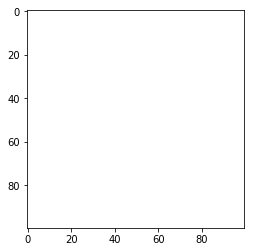

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


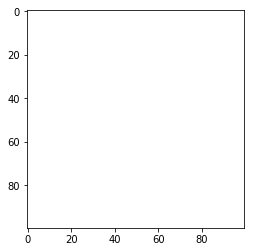

([array([[[[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          ...,
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 

In [26]:
prepare_batch(32)

In [0]:
def generate_batches(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [0]:
def make_oneshot_task(N, s="val"):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    
    n_examples, w, h, _ = X.shape
    
    indices = np.random.randint(0, n_examples,size=(N,))
    
    categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [0]:
model.load_weights(os.path.join(model_path, "weights.h5"))

In [0]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = prepare_batch(batch_size)
    print(len(inputs), len(targets))
    loss = model.train_on_batch(inputs, targets)
    if i % 10 == 0: #evaluate_every
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        #val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        #if val_acc >= best:
        #    print("Current best: {0}, previous best: {1}".format(val_acc, best))
        #    best = val_acc
